In [42]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns



/tmp/ipykernel_2972341/2028493022.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Labels from the mask: [  0   8   9  10  40  94 105 106 117 121]
Cell 1: {'Area': 75172.0, 'Perimeter': 2180.77878733769, 'Solidity': 0.761435922369434, 'Extent': 0.6484817115251897, 'Circularity': 0.1986290387825207, 'Convexity': 45.2700661677487, 'Elongation': 0.826191528550034, 'Compactness': 0.3824252300359386}
Cell 2: {'Area': 35084.0, 'Perimeter': 1400.025432638166, 'Solidity': 0.8709381128515751, 'Extent': 0.6510298756726666, 'Circularity': 0.22492986169453558, 'Convexity': 28.773048732473324, 'Elongation': 0.892228086129317, 'Compactness': 0.3183836665628814}
Cell 3: {'Area': 27339.0, 'Perimeter': 966.9970414071697, 'Solidity': 0.8244323150689062, 'Extent': 0.5665174686062414, 'Circularity': 0.3674025771561477, 'Convexity': 34.292762624944814, 'Elongation': 0.6611074313753333, 'Compactness': 0.5277509091738458}
Cell 4: {'Area': 75087.0, 'Perimeter': 2824.124025129251, 'Solidity': 0.5620284431137724, 'Extent': 0.4169623669348793, 'Circularity': 0.11830608591242286, 'Convexity': 4

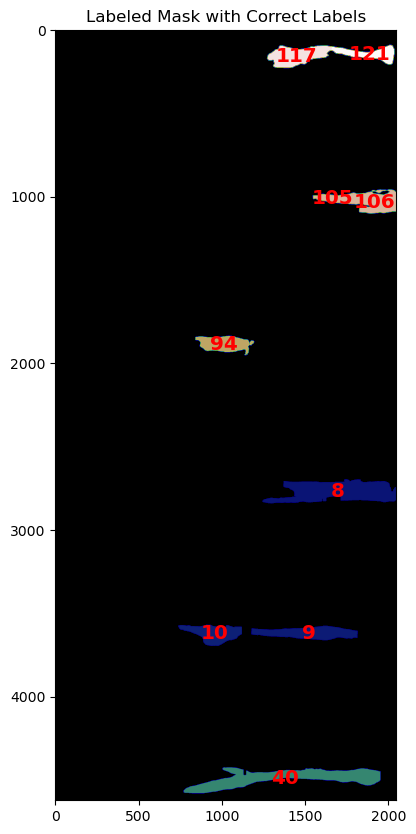

In [4]:
def analyze_mask_with_shape_factors(frame, mask_path_template, size_threshold=1000):
    

    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:  # Skip background label
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return {
            "Area": area,
            "Perimeter": perimeter,
            "Solidity": solidity,
            "Extent": extent,
            "Circularity": circularity,
            "Convexity": convexity,
            "Elongation": elongation,
            "Compactness": compactness,
        }

    # Load the mask image using imageio
    mask_path = mask_path_template.format(frame=frame)
    mask = imageio.imread(mask_path)

    # Print the labels directly from the mask
    unique_labels = np.unique(mask)
    print("Labels from the mask:", unique_labels)

    # Measure the properties of the labeled regions
    properties = regionprops(mask)

    # Apply a size threshold to filter out small artifacts
    filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

    # Calculate shape factors for filtered regions
    shape_factors_list = [calculate_shape_factors(region) for region in filtered_regions]

    # Display the results
    for idx, factors in enumerate(shape_factors_list):
        print(f"Cell {idx + 1}: {factors}")

    # Plot the labels for filtered cells, excluding the background label
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_labels(mask, ax, title="Labeled Mask with Correct Labels")
    plt.show()

# Example usage
frame = 65
# mask_path_template = "/path/to/mask_{frame:04d}.tif"  # Update the path
mask_path_template = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA/mask{frame:04d}.tif"
analyze_mask_with_shape_factors(frame, mask_path_template)


In [4]:
import os
from skimage.measure import regionprops, label
import numpy as np
import imageio
import pandas as pd
from scipy.spatial import distance  # For centroid matching

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """
    Analyze and track cells across multiple frames and store results by Cell ID.
    
    Parameters:
        mask_directory (str): Path to the directory containing mask files.
        output_directory (str): Path to the directory where the CSV file will be saved.
        size_threshold (int): Minimum size threshold for filtering small artifacts.
        max_centroid_dist (int): Maximum allowed distance to match cells across frames.
    
    Saves:
        A CSV file containing shape factor results with cells tracked across frames in the specified directory.
    """
    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    # Get all mask files in the directory, sorted by filename
    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    print(f"Found {len(mask_files)} mask files in the directory.")

    # To store cell tracking data
    all_results = []
    cell_tracks = {}  # Mapping of Cell ID to its most recent centroid

    current_cell_id = 1

    for frame_idx, mask_path in enumerate(mask_files):
        # Extract frame number from the filename (optional for tracking)
        frame = os.path.basename(mask_path).split('.')[0]

        # Load the mask image using imageio
        mask = imageio.imread(mask_path)

        # Measure the properties of the labeled regions
        properties = regionprops(mask)

        # Apply a size threshold to filter out small artifacts
        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        # Prepare a mapping for this frame
        frame_results = []

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid

            # Attempt to match this cell with an existing cell track
            matched_cell_id = None
            for cell_id, prev_centroid in cell_tracks.items():
                if distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    break

            if matched_cell_id is None:
                # No match found; assign a new Cell ID
                matched_cell_id = current_cell_id
                current_cell_id += 1

            # Update the cell's most recent centroid
            cell_tracks[matched_cell_id] = centroid

            # Append results: Cell ID, Frame, and Shape Factors
            frame_results.append([matched_cell_id, frame] + shape_factors)

        # Add frame results to the main results
        all_results.extend(frame_results)

        print(f"Processed frame {frame}: {len(filtered_regions)} cells detected.")

    # Define column names
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
               "Circularity", "Convexity", "Elongation", "Compactness"]

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results, columns=columns)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Save results to the specified output directory
    output_file_path = os.path.join(output_directory, "tracked_cells_across_frames.csv")
    results_df.to_csv(output_file_path, index=False)
    print(f"Results saved to {output_file_path}")

    return results_df

# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"  # Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"  # Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head())



Found 100 mask files in the directory.
Processed frame mask0000: 12 cells detected.


/tmp/ipykernel_2974488/1763024439.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Processed frame mask0001: 12 cells detected.
Processed frame mask0002: 12 cells detected.
Processed frame mask0003: 12 cells detected.
Processed frame mask0004: 13 cells detected.
Processed frame mask0005: 12 cells detected.
Processed frame mask0006: 12 cells detected.
Processed frame mask0007: 12 cells detected.
Processed frame mask0008: 11 cells detected.
Processed frame mask0009: 11 cells detected.
Processed frame mask0010: 11 cells detected.
Processed frame mask0011: 12 cells detected.
Processed frame mask0012: 11 cells detected.
Processed frame mask0013: 11 cells detected.
Processed frame mask0014: 10 cells detected.
Processed frame mask0015: 9 cells detected.
Processed frame mask0016: 10 cells detected.
Processed frame mask0017: 9 cells detected.
Processed frame mask0018: 9 cells detected.
Processed frame mask0019: 10 cells detected.
Processed frame mask0020: 11 cells detected.
Processed frame mask0021: 10 cells detected.
Processed frame mask0022: 10 cells detected.
Processed fra

In [5]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """
    Analyze and track cells across multiple frames and store results by Cell ID.
    
    Parameters:
        mask_directory (str): Path to the directory containing mask files.
        output_directory (str): Path to the directory where the CSV file will be saved.
        size_threshold (int): Minimum size threshold for filtering small artifacts.
        max_centroid_dist (int): Maximum allowed distance to match cells across frames.
    
    Saves:
        A CSV file containing shape factor results with cells tracked across frames in the specified directory.
    """
    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    # Get all mask files in the directory, sorted by filename
    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    print(f"Found {len(mask_files)} mask files in the directory.")

    # To store cell tracking data
    all_results = []
    cell_tracks = {}  # Mapping of Cell ID to its most recent centroid

    current_cell_id = 1

    for mask_path in mask_files:
        # Extract frame number from the filename
        frame = os.path.basename(mask_path).split('.')[0]

        # Load the mask image using imageio
        mask = imageio.imread(mask_path)

        # Measure the properties of the labeled regions
        properties = regionprops(mask)

        # Apply a size threshold to filter out small artifacts
        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid

            # Attempt to match this cell with an existing cell track
            matched_cell_id = None
            for cell_id, prev_centroid in cell_tracks.items():
                if distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    break

            if matched_cell_id is None:
                # No match found; assign a new Cell ID
                matched_cell_id = current_cell_id
                current_cell_id += 1

            # Update the cell's most recent centroid
            cell_tracks[matched_cell_id] = centroid

            # Append results: Cell ID, Frame, and Shape Factors
            all_results.append([matched_cell_id, frame] + shape_factors)

    # Define column names
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
               "Circularity", "Convexity", "Elongation", "Compactness"]

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results, columns=columns)

    # Sort by Cell Number and Frame
    results_df = results_df.sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Save results to the specified output directory
    output_file_path = os.path.join(output_directory, "tracked_cells_across_frames.csv")
    results_df.to_csv(output_file_path, index=False)
    print(f"Results saved to {output_file_path}")

    return results_df

# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"  # Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"  # Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head())


Found 100 mask files in the directory.


/tmp/ipykernel_2974488/451183901.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Results saved to /home/MinaHossain/DMNet_Rina_Tracking/tracked_cells_across_frames.csv
   Cell Number     Frame     Area    Perimeter  Solidity    Extent  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Circularity  Convexity  Elongation  Compactness  
0     0.138689  19.788763    0.938314     0.226238  
1     0.202638  19.606899    0.908014     0.285745  
2     0.115715  18.535536    0.945193     0.217443  
3     0.466687  32.799205    0.562733     0.603899  
4     0.530747  34.769063    0.569925     0.602088  


#  Calculation of  non-dimensional  shape factors for the track cells across multiple frames and store results by Cell ID.

In [8]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255  # Convert to 0-255 format
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation","Circularity", "Convexity"]
    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

Found 100 mask files.
Execution Time: 19.90 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Compactness  Elongation  Circularity  Convexity  
0     0.138689    0.975886     0.938314   0.226238  
1     0.202638    0.981629     0.908014   0.285745  
2     0.115715    0.981184     0.945193   0.217443  
3     0.466687    0.918934     0.562733   0.603899  
4     0.530747    0.972914     0.569925   0.602088  


#  Calculation of  non-dimensional  shape factors for the HP4_TRA across multiple frames and store results by Cell ID (/data/MinaHossain/Cell_Data/Fall-2024/Track_Result).

In [9]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255  # Convert to 0-255 format
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation","Circularity", "Convexity"]
    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

Found 100 mask files.
Execution Time: 20.54 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   

   Compactness  Elongation  Circularity  Convexity  
0     0.145967    0.979877     0.936470   0.230860  
1     0.194602    0.973082     0.912320   0.276314  
2     0.115376    0.983563     0.944456   0.219650  
3     0.461899    0.907567     0.550963   0.612606  
4     0.538978    0.967665     0.554315   0.614792  


# Modified Code to Include Centroid Calculation

In [11]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors and centroids in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    # Update column names to include centroid (X, Y)
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_centroid-HP3_{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

Found 100 mask files.
Execution Time: 20.02 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  
0     0.138689    0.975886     0.938314   0.226238   506.383747   88.009625  
1     0.202638    0.981629     0.908014   0.285745   514.983176   97.383428  
2     0.115715    0.981184     0.945193   0.217443   505.423508   97.804470  
3     0.466687    0.918934     0.562733   0.603899  1924.020589  141.251686  
4     0.530747    0.972914     0.569925   0.602088  1924.333875  143.253211  


# Find the Centroid Distance of the cells


In [28]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, and centroid distances in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            # Find the closest matching cell from the previous frame
            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            # Calculate distance from previous centroid (if available)
            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            if prev_x is not None and prev_y is not None:
                centroid_distance = distance.euclidean((prev_x, prev_y), centroid)
            else:
                centroid_distance = 0  # First occurrence of this cell

            # Update previous centroid storage
            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            # Store results: Cell ID, Frame, Shape Factors, Centroid (X, Y), Centroid Distance
            all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

    # Update column names to include centroid (X, Y) and distance
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Distance_HP3-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df





mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

Found 100 mask files.
Execution Time: 19.80 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0     0.138689    0.975886     0.938314   0.226238   506.383747   88.009625   
1     0.202638    0.981629     0.908014   0.285745   514.983176   97.383428   
2     0.115715    0.981184     0.945193   0.217443   505.423508   97.804470   
3     0.466687    0.918934     0.562733   0.603899  1924.020589  141.251686   
4     0.530747    0.972914     0.569925   0.602088  1924.333875  143.253211   

   Centroid_Distance  
0           0.000000  
1     

# visualize_3D_centroid_movement plot

Found 100 mask files.
Results saved to /home/MinaHossain/DMNet_Rina_Tracking/Cells_Centoid_Distance_HP3_Plot_20250117_083220.csv
Execution Time: 19.71 seconds
3D plot saved at: /home/MinaHossain/DMNet_Rina_Tracking/3D_Cell_Centroid_Movement_Over_Frame_HP3.png
3D plot saved at: /home/MinaHossain/DMNet_Rina_Tracking/3D_Cell_Centroid_Movement_Over_Frame_HP3.png
   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19221.0  1319.688384  0.736014  0.493961     0.138689   
1            1     22  15870.0   992.048773  0.815896  0.644493     0.202638   
2            1     26  23669.0  1603.244733  0.796480  0.563279     0.115715   
3            2      0  19719.0   728.676190  0.825063  0.617299     0.466687   
4            2      1  20319.0   693.605122  0.842553  0.611834     0.530747   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.975886     0.938314   0.226238   506.383747   88.009625   
1    0.981629     0.908014

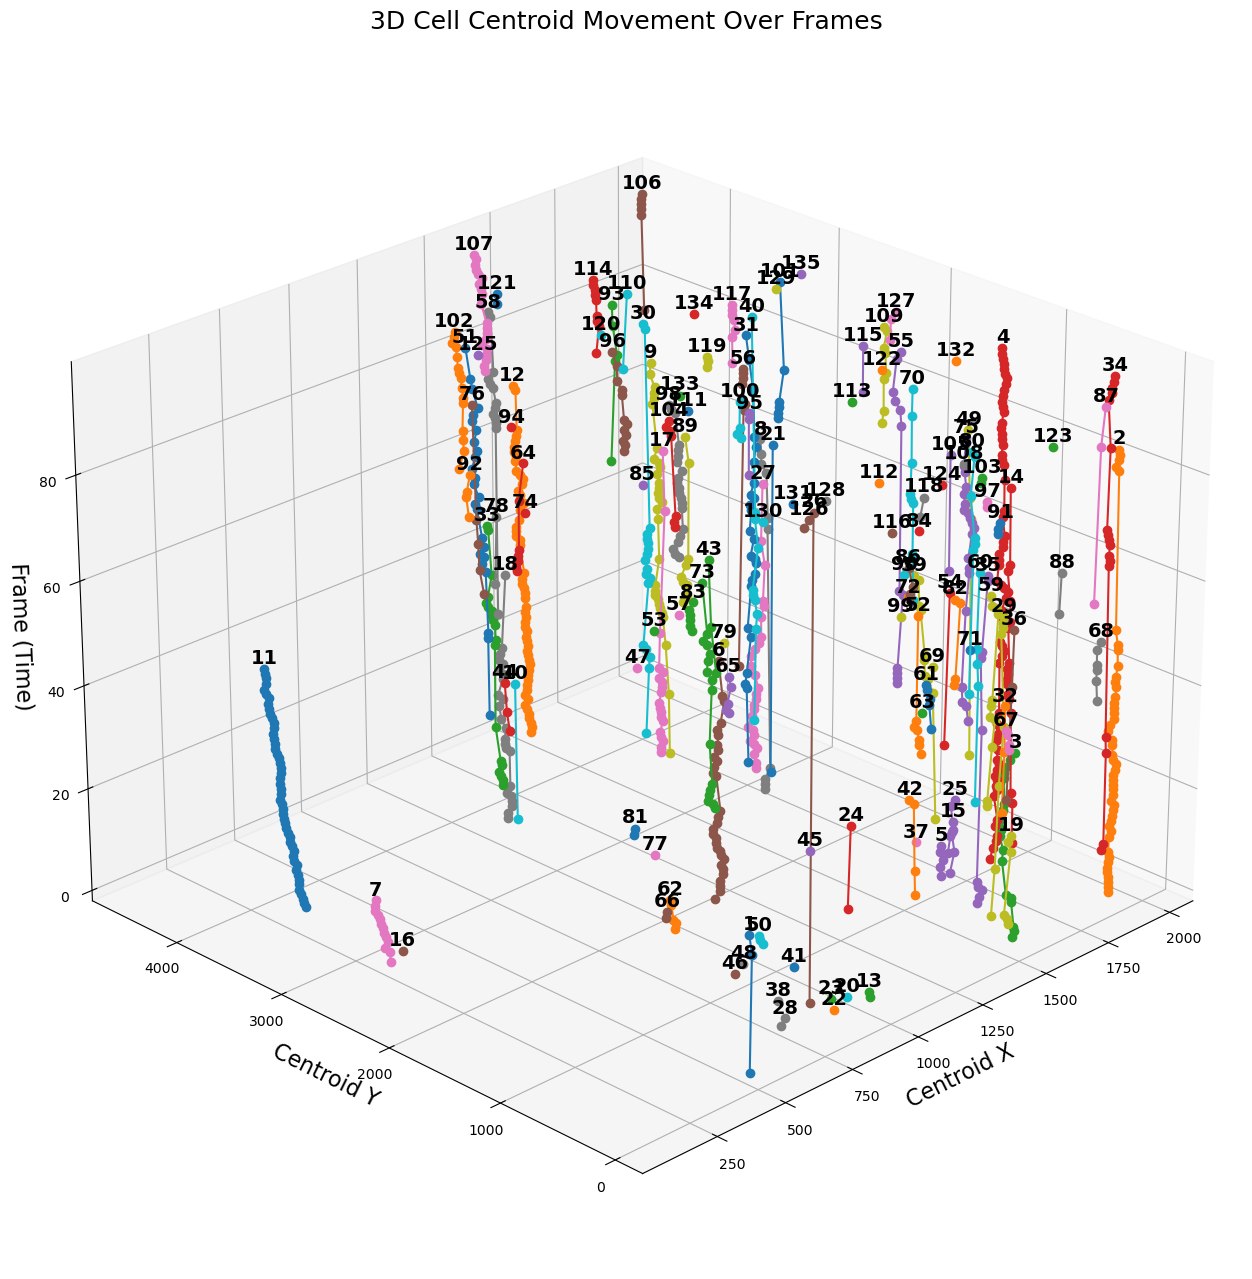

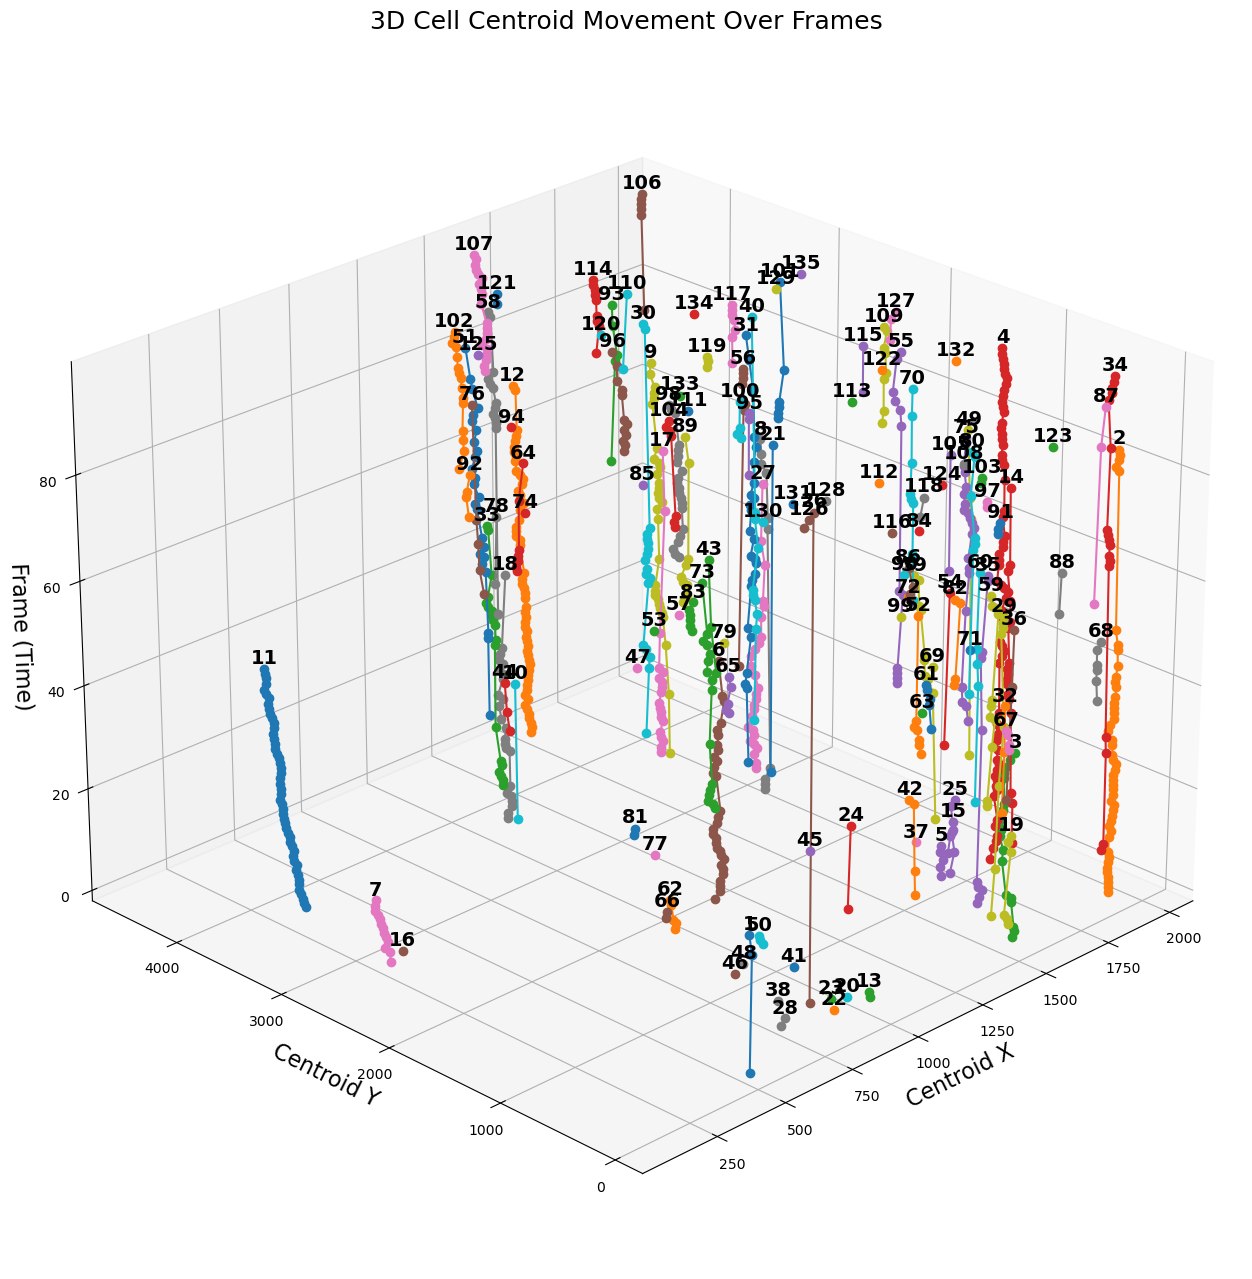

In [29]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, and visualize centroid movement."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        # Extract frame number from filename
        frame_match = re.search(r'\d+', os.path.basename(mask_path))  # Extracts digits
        frame = int(frame_match.group()) if frame_match else 0  # Convert to int or default to 0

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            # Find the closest matching cell from the previous frame
            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            # Calculate distance from previous centroid (if available)
            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            if prev_x is not None and prev_y is not None:
                centroid_distance = distance.euclidean((prev_x, prev_y), centroid)
            else:
                centroid_distance = 0  # First occurrence of this cell

            # Update previous centroid storage
            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            # Store results: Cell ID, Frame, Shape Factors, Centroid (X, Y), Centroid Distance
            all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

    # Update column names to include centroid (X, Y) and distance
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = os.path.join(output_directory, f"Cells_Centoid_Distance_HP3_Plot_{timestamp}.csv")
    results_df.to_csv(csv_filename, index=False)

    print(f"Results saved to {csv_filename}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")

    # Visualize 3D centroid movement
    visualize_3D_centroid_movement(results_df, output_directory)

    return results_df


def visualize_3D_centroid_movement(results_df, output_directory):
    """3D Plot of Cell Centroid Movement Over Frames with Cell Number Labels & Save the Plot."""
    fig = plt.figure(figsize=(20, 16))  # Large plot size
    ax = fig.add_subplot(111, projection='3d')

    for cell_id, group in results_df.groupby("Cell Number"):
        ax.plot(group["Centroid_X"], group["Centroid_Y"], group["Frame"], marker='o', linestyle='-')

        last_row = group.iloc[-1]  # Last position of the cell
        ax.text(last_row["Centroid_X"], last_row["Centroid_Y"], last_row["Frame"] + 1,  # Offset Z for clarity
                str(int(cell_id)), color='black', fontsize=14, weight='bold', ha='center')

    ax.set_xlabel("Centroid X", fontsize=16)
    ax.set_ylabel("Centroid Y", fontsize=16)
    ax.set_zlabel("Frame (Time)", fontsize=16)
    ax.set_title("3D Cell Centroid Movement Over Frames", fontsize=18)
    ax.view_init(elev=25, azim=225)

    os.makedirs(output_directory, exist_ok=True)
    plot_filename = os.path.join(output_directory, "3D_Cell_Centroid_Movement_Over_Frame_HP3.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"3D plot saved at: {plot_filename}")

    # plt.show()


#######  Example usage


mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Generate & Save the 3D Plot
visualize_3D_centroid_movement(results_df, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

# PCA for Clustering the cells

Found 100 mask files.


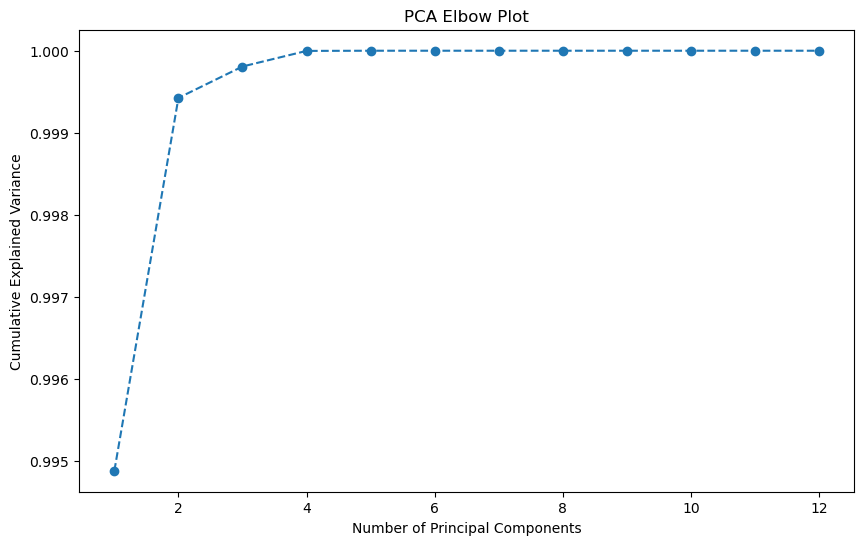

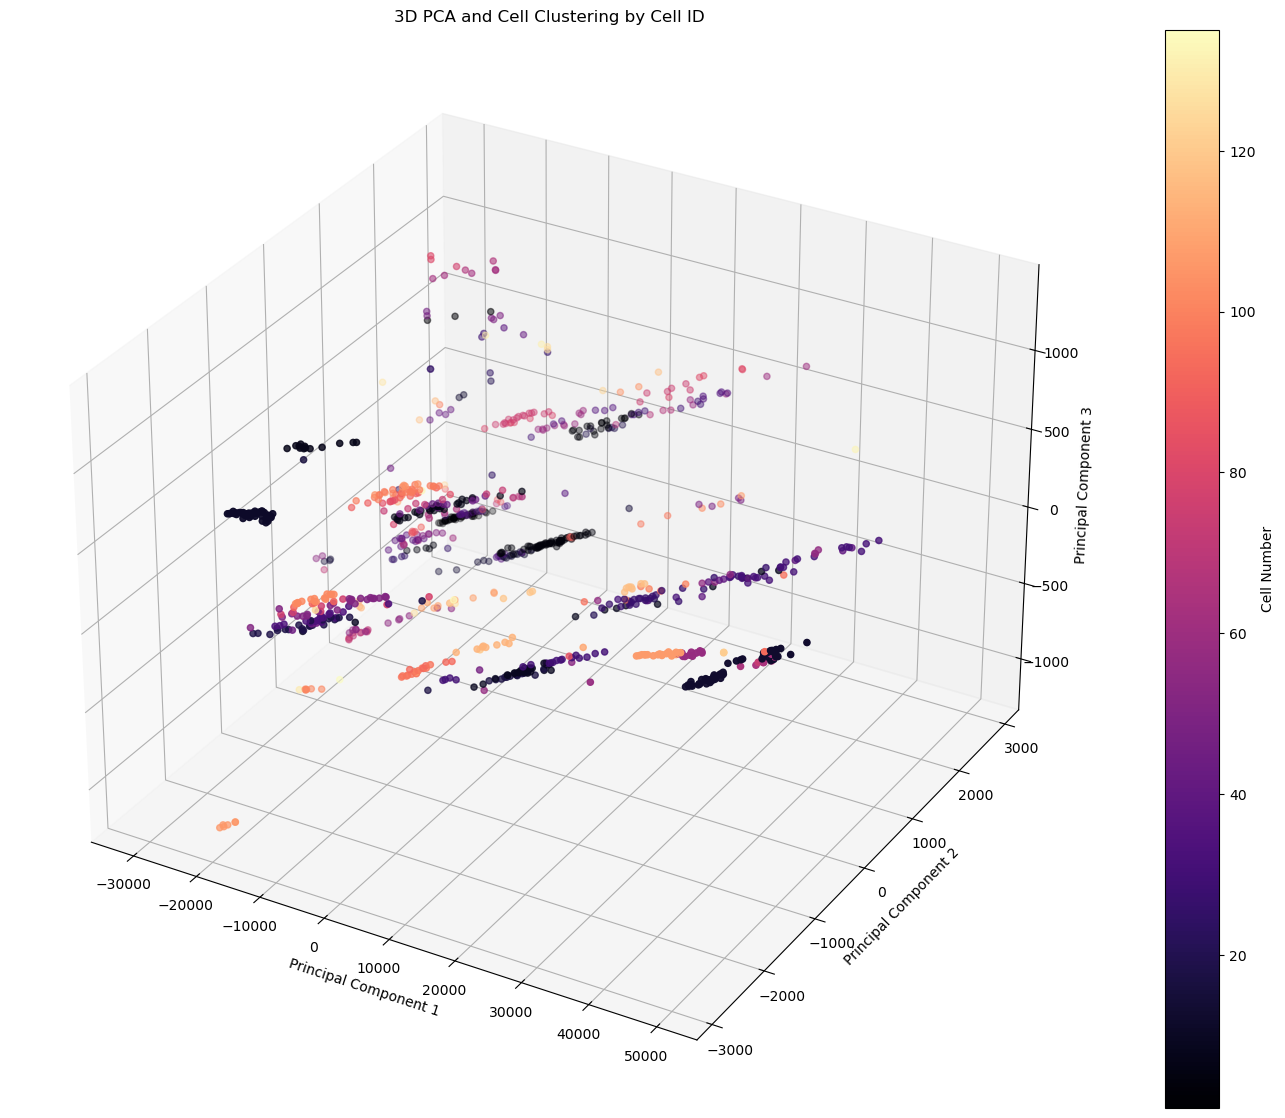

   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19221.0  1319.688384  0.736014  0.493961     0.138689   
1            1     22  15870.0   992.048773  0.815896  0.644493     0.202638   
2            1     26  23669.0  1603.244733  0.796480  0.563279     0.115715   
3            2      0  19719.0   728.676190  0.825063  0.617299     0.466687   
4            2      1  20319.0   693.605122  0.842553  0.611834     0.530747   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.975886     0.938314   0.226238   506.383747   88.009625   
1    0.981629     0.908014   0.285745   514.983176   97.383428   
2    0.981184     0.945193   0.217443   505.423508   97.804470   
3    0.918934     0.562733   0.603899  1924.020589  141.251686   
4    0.972914     0.569925   0.602088  1924.333875  143.253211   

   Centroid_Distance  
0           0.000000  
1          12.720785  
2           9.568936  
3           0.000000  
4      

In [45]:


def analyze_and_cluster_cells(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, n_clusters=4):
    """Analyze and track cells across frames, then apply PCA and cluster them."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        filename = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', filename)
        frame = int(frame_match.group()) if frame_match else 0
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            centroid_distance = distance.euclidean((prev_x, prev_y), centroid) if prev_x is not None else 0

            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    if results_df.empty:
        print("No valid data to process.")
        return None

    # PCA elbow plot
    pca = PCA()
    pca.fit(results_df[columns[1:]])
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(columns)), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Elbow Plot")
    plt.show()
    
    # Apply PCA for clustering
    pca = PCA(n_components=4)
    transformed_data = pca.fit_transform(results_df[columns[1:]])

    # 3D PCA plot
    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=results_df["Cell Number"], cmap='magma')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("3D PCA and Cell Clustering by Cell ID")
    plt.colorbar(scatter, ax=ax, label="Cell Number")
    plt.show()
    
    return results_df


# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

results_dff = analyze_and_cluster_cells(mask_directory, output_directory)

# Display first few rows
if results_dff is not None:
    print(results_dff.head())